### Backwards Regression
#### Joseph Scarpa (jcs140)

In [ ]:
# Imports (update throughout as necessary)
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt # just to format confusion matrix

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

import re



#### Data loading and cleaning

Notes:
* No null values found
* No duplicate values found

In [ ]:
# Data loading
data10 = pd.read_csv('./datasets/dataset-of-10s.csv')
data00 = pd.read_csv('./datasets/dataset-of-00s.csv')
data90 = pd.read_csv('./datasets/dataset-of-90s.csv')
data80 = pd.read_csv('./datasets/dataset-of-80s.csv')
data70 = pd.read_csv('./datasets/dataset-of-70s.csv')
data60 = pd.read_csv('./datasets/dataset-of-60s.csv')

In [ ]:
# Data cleaning

# Drop all na values
data10 = data10.dropna()
data00 = data00.dropna()
data90 = data90.dropna()
data80 = data80.dropna()
data70 = data70.dropna()
data60 = data60.dropna()


# Add a decades column to each dataset (will be helpful when creating cumulative dataset)
data10['decade'] = [2010]*len(data10)
data00['decade'] = [2000]*len(data00)
data90['decade'] = [1990]*len(data90)
data80['decade'] = [1980]*len(data80)
data70['decade'] = [1970]*len(data70)
data60['decade'] = [1960]*len(data60)

In [ ]:
# Check for duplicates in dataset
merged = data10.merge(data00,on=['track','artist'])
merged = merged.merge(data90,on=['track','artist'])
merged = merged.merge(data80,on=['track','artist'])
merged = merged.merge(data70,on=['track','artist'])
merged = merged.merge(data60,on=['track','artist'])
merged
# NOTE: No duplicates found

,uri_x,danceability_x,energy_x,key_x,loudness_x,mode_x,speechiness_x,acousticness_x,instrumentalness_x,liveness_x,...,instrumentalness_y,liveness_y,valence_y,tempo_y,duration_ms_y,time_signature_y,chorus_hit_y,sections_y,target_y,decade_y


In [ ]:
# Create cumulative dataset (from songs across all decades)
data = data10.append(data00,ignore_index=True).append(data90,ignore_index=True).append(data80,ignore_index=True).append(data70,ignore_index=True).append(data60,ignore_index=True)
data.head()
data.tail()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
41101,Le ire di Ursus,Giampiero Boneschi,spotify:track:3dVgolCVuNgecU5jovpc45,0.420,0.8730,3,-11.689,1,0.1000,0.808,0.879000,0.363,0.183,119.821,26244,4,0.00000,2,0,1960
41102,A-B-C,John Zacherle,spotify:track:0zXhzKf4raEYstebL7L42C,0.716,0.7420,10,-5.727,0,0.2420,0.663,0.000000,0.107,0.834,135.104,142987,4,28.34316,10,0,1960
41103,Useless Landscape,Antônio Carlos Jobim,spotify:track:2uC02PCRVM6BhAaK7dgxxp,0.361,0.0944,10,-22.663,1,0.0327,0.940,0.000178,0.115,0.139,92.472,137200,4,56.63498,6,0,1960
41104,Vendedor De Assaí,Ary Lobo,spotify:track:0gpSUWZWNIRrEenaC1ZGk9,0.452,0.7590,4,-7.821,0,0.1750,0.658,0.000000,0.738,0.853,137.976,159107,3,28.24372,9,0,1960
41105,Mambo Simphony - Remasterizado,Orquesta Casino De La Playa,spotify:track:5j0G0nkCSPlmSCSgXchMn3,0.554,0.2780,5,-8.386,1,0.0349,0.928,0.922000,0.136,0.428,131.401,164227,4,37.39251,8,0,1960


In [ ]:
# Add custom columns that will be useful later

# Duration of song in seconds
data["duration_sec"] = np.round(data["duration_ms"]*(1/1000))
data["duration_sec"]

# Loudness of sound (rounded)
data["loudness_rounded"] = np.round(data["loudness"])
data["loudness_rounded"]

0        -5.0
1       -15.0
2        -7.0
3        -6.0
4        -4.0
         ... 
41101   -12.0
41102    -6.0
41103   -23.0
41104    -8.0
41105    -8.0
Name: loudness_rounded, Length: 41106, dtype: float64

In [ ]:
#Joey
knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(knn, n_features_to_select=3)
#X is 2d array of samples and features
propColData = data[['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'valence']].to_numpy()
propColData
#Y is hit vs flop. .
targetData = data['target'].to_numpy()
targetData
#Fit the model
sfs.fit(propColData, targetData)
sfs.get_support()
'''Indicates that danceability, energy, and instrumentalness together
better predict whether a song is a hit or a flop than other 
combinations of these things.'''



'Indicates that danceability, energy, and instrumentalness together\nbetter predict whether a song is a hit or a flop than other \ncombinations of these things.'

[[ 3.54106093  0.78182681 -3.63626988]]
0.7033279813165961
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


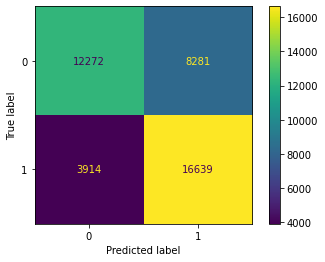

In [ ]:
#Joey: Regression on selected factors. 
#Get relevant columns as data
dataSelectedSubsetData = data[['danceability', 'energy', 'instrumentalness']].values

#Fit model
logm_die = LogisticRegression()
logm_die.fit(X = dataSelectedSubsetData, y = targetData)

#Get coefficients for model. 
print(logm_die.coef_)

#Get accuracy score
predictions = logm_die.predict(dataSelectedSubsetData)
logm_die_accscore = accuracy_score(targetData, predictions)
print(logm_die_accscore)

#Recall versus Sensitivity. 
#Precision and Recall Scores

plot_confusion_matrix(logm_die, dataSelectedSubsetData, targetData)



In [ ]:
print(metrics.precision_score(targetData, predictions))
print(metrics.recall_score(targetData, predictions))
print(metrics.f1_score(targetData, predictions))

0.6676966292134832
0.8095655135503332
0.7318188815340971


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=162d76af-48a2-4f75-9aef-34643a48aa39' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>